# Segmentation 220830
 - Goal: 95%+ F1 on WADS

2D approaches needs 3D post proccess (unless someone uses fft to make the convertion 1 to 1). This puts us at 3D time complexity which defeats the point of using 2D, as noted by Johan Bergius. 

On Second thought, since all vetors have a common centroid it is mathematically possible to reduce dimensionality of the convolution by 1 (see [Divergence theorem](https://en.wikipedia.org/wiki/Divergence_theorem)). Given that the curl is zero there should be 1 to 1 transform from 3d to 2d space. Will use salsa next as base approach.

TODO:
- replace salsas fake knn with proper knn
- use gan
- include postprocess in backpropagation
- make/find scale invariance | can be improved but no reports on full invariance found
- investigate more informative 2d views

Done:
- add knn/mlp to current model | Added salsa knn
- augment | Added y rotation and flip

Notes:
- x,y,z channel noise outweight the benefits!
- dropout leads to underfit
- full set > clean subset
- augmentation is a requirement

## Import and globals

In [1]:
from IO import read_kitty, write_one_kitty
import yaml
import numpy as np
import numpy.linalg as LA
import matplotlib.pyplot as plt
import torch
from torchsummary import summary
from torchinfo import summary as info_summary
from itertools import chain, repeat, product, islice
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import f1_score, recall_score, precision_score
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init
from time import time

config = yaml.safe_load(open('./net_config.yaml'))
print(*config.items(), sep='\n')

('generator', {'lr': 0.001})
('discriminator', {'lr': 0.001})
('data_loader', {'train': ['11', '12', '13', '14', '15', '16', '17', '18', '20', '22', '23', '24', '26'], 'valid': ['11', '12', '13', '14', '15', '16', '17', '18', '20', '22', '23', '24', '26'], 'test': ['30', '34', '35', '36', '76']})
('run', {'device': 1, 'cuda': True, 'seed': 42})
('train', {'disc_loops': 2, 'batch_size': 1, 'max_epoch': 25, 'log_name': 'test', 'checkpoint': 9001})
('eval', {'save': 2})


## Build dataloader

In [2]:
points, labels = read_kitty(config['data_loader']['train'], max_len=1)
sample = next(iter(points['11'].values()))
print('Point cloud shape:', sample.shape)
print(*sample[:5],sep='\n')
sample = next(iter(labels['11'].values()))
print('\nLabel shape:', sample.shape)
print(*sample[:5],sep='\n')

Point cloud shape: (115881, 4)
[-197.84776     26.662176     3.9865794   13.       ]
[-197.78802     25.835665     2.8061757    6.       ]
[-197.77983     25.658987     1.0338181   10.       ]
[-197.77368     26.125235     2.2110257    9.       ]
[-197.7581      26.23899      3.3880968   13.       ]

Label shape: (115881, 2)
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]


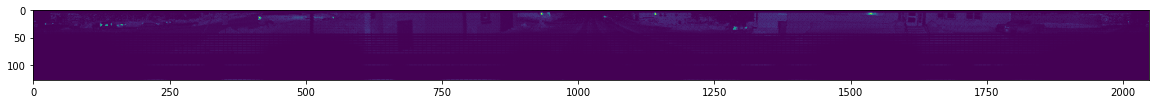

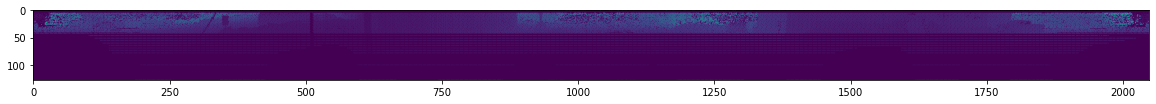

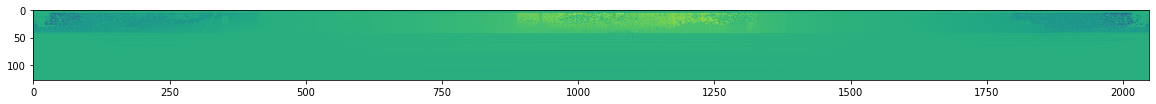

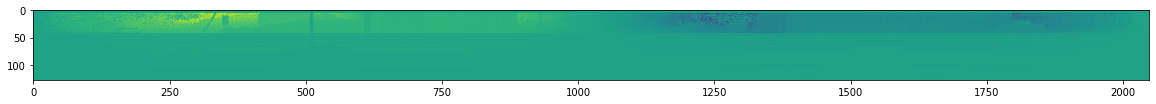

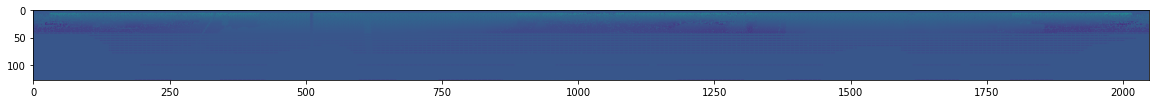

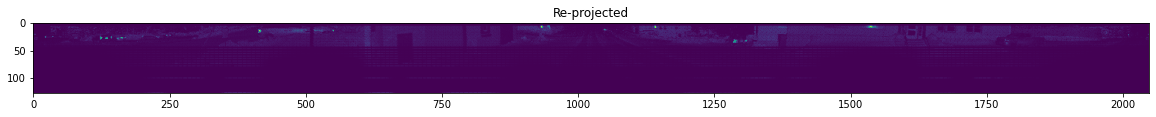

In [3]:
def project(points, vertical_fov:tuple=(3.0,-25.0), out_shape:tuple=(128,2048), return_xyr:bool=False):
    # unpack params to short names
    P = points.copy()
    fov_up, fov_down = vertical_fov
    height, width = out_shape
    x, y, z = P[:,0], P[:,1], P[:,2]

    # Compute spherical coordinates
    r = LA.norm(P[:,:3], 2, axis=1)
    yaw = -np.arctan2(y, x)
    pitch = np.arcsin(z / r)
    
    # Parameters of the LiDAR
    fov_up = fov_up / 180.0 * np.pi  # field of view up in rad
    fov_down = fov_down / 180.0 * np.pi  # field of view down in rad
    fov = abs(fov_down) + abs(fov_up)  # field of view total in rad

    # get projections in image coords
    clamp = lambda x,m: np.maximum(0, np.minimum(np.round(x),m)).astype(np.int32)
    
    proj_x = 0.5 * (yaw / np.pi + 1.0)  # in the set [0.0, 1.0]
    proj_x *= width  # in [0.0, W]
    proj_x = clamp(proj_x, width-1) # in [0,W-1]
    
    proj_y = 1.0 - (pitch + abs(fov_down)) / fov  # in the set [0.0, 1.0]
    proj_y *= height  # in [0.0, H]
    proj_y = clamp(proj_y, height-1)  # in [0,H-1]

    # order in decreasing depth
    if return_xyr:
        p_x, p_y, p_r = proj_x.copy(), proj_y.copy(), r.copy()
    rev_indices = np.arange(r.shape[0])
    indices = np.argsort(r)[::-1]
    P, proj_y, proj_x = P[indices], proj_y[indices], proj_x[indices]
    r, rev_indices = r[indices], rev_indices[indices]
    
    # build projected image data
    proj = np.full((height, width, 6), -1, dtype=np.float32)
    proj[proj_y, proj_x, 0] = P[:,3]
    proj[proj_y, proj_x, 1] = r
    proj[proj_y, proj_x, 2:5] = P[:,0:3]
    proj[proj_y, proj_x, 5] = rev_indices # maps from point cloud to projection (not the other way!)
    
    if return_xyr:
        ret = (proj, p_x, p_y, p_r)
        assert len(ret) == 4 # because pytorch messing with how things are packed
        return ret
    return proj


def unproject(projection, vertical_fov:tuple=(3.0,-25.0), return_mask=False):
    "convert 2d image to 3d point cloud. [height, width, channels] -> [index, channels]"
    
    fov_up, fov_down = vertical_fov
    height, width, channels = projection.shape
    
    # Parameters of the LiDAR
    fov_up = fov_up / 180.0 * np.pi  # field of view up in rad
    fov_down = fov_down / 180.0 * np.pi  # field of view down in rad
    fov = abs(fov_down) + abs(fov_up)  # field of view total in rad
    
    # compute point cloud
    p = -np.ones((height*width, 4), dtype=np.float32) # init as -1 to remove dead pixels later
    for y,x in product(range(height), range(width)):
        #compute target index
        index = y*width+x # or x*height+y
        
        # Get spherical coordinates
        intensity, r = projection[y, x, :2]
        if r == -1: continue # if magic number -1 then there's no data
        x /= width # normalize
        yaw = 2.0 * np.pi * (-x) 
        y /= height # normalize
        pitch = fov*(1.0-y) - abs(fov_down) - np.pi/2
        
        # Compute cartesian coordinates
        x = np.cos(yaw) * np.sin(pitch) * r
        y = np.sin(yaw) * np.sin(pitch) * r
        z = np.cos(pitch) * r
        
        # Add data to array
        p[index, 0] = x
        p[index, 1] = y
        p[index, 2] = z
        p[index, 3] = intensity
        
    mask = p[:,3]!=-1
    p = p[mask] # remove points with no data
    
    if return_mask:
        return p, mask
    return p
 
    
# print sample images to validate
%matplotlib inline
sample = next(iter(points['18'].values()))
projected = project(sample)

for i in range(0,5):
    plt.figure(figsize=(20, 6));
    plt.imshow(projected[:,:,i]);

# sanity check. intensity sum should be the same before and after
assert unproject(projected)[:,3].sum() == projected[:,:,0].sum() + sum(projected[:,:,0].flat==-1)
# sanity check. unprojected points can't be further away than max radius
assert max(projected[:,:,1].flat) > max([max(abs(unproject(projected)[:,i])) for i in range(3)])

plt.figure(figsize=(20, 6));
plt.title('Re-projected')
plt.imshow((project(unproject(projected)))[:,:,0]);

In [4]:
start_time = time()
outlier_labels = [110] # 110 = falling snow
seq_lenths = None

# declare iterators to flatten nested dicts (sorry about the itertool mess)
flat_values = lambda points: chain(*chain((*p.values(),) for p in points.values()))
flat_keys = lambda points: chain(*chain((*zip( repeat(k, len(p.keys())), p.keys() ),) for k,p in points.items()))

# train loader
points, labels = read_kitty(config['data_loader']['train'], max_len=seq_lenths)
mask = [~np.isin(frame[:,0], outlier_labels) for frame in flat_values(labels)]
clean = [project(p[m])[:,:,:-4].transpose(2, 0, 1) for p,m in zip(flat_values(points),mask)]
snowy = [project(p)[:,:,[0,1,5]].transpose(2, 0, 1) for p in flat_values(points)] # keep last channel (rev indices)
rev_indices = [data[-1,:,:].astype(np.int32) for data in snowy] # extract reverse indices
snowy = [s[:-1,:,:] for s in snowy] # drop them
label = [lab[i].transpose(2, 0, 1) for lab,i in zip(flat_values(labels),rev_indices)]
binary_label = [np.isin(lab[0], outlier_labels).astype(int) for lab in label]
#binary_label = np.ndarray((len(binary_label),1,*binary_label[0].shape), dtype=np.ubyte) # speed up
binary_label = torch.tensor(binary_label, dtype=torch.float32).reshape(-1,1,*snowy[0].shape[1:])
train_loader = torch.utils.data.DataLoader(
    [*zip(snowy,binary_label)],
    shuffle=True, 
    batch_size=config['train']['batch_size'])
x,y = next(iter(train_loader))
print(x.shape, y.shape)

# test loader
points, labels = read_kitty(config['data_loader']['test'], max_len=None)#seq_lenths*3)
mask = [~np.isin(frame[:,0], outlier_labels) for frame in flat_values(labels)] # select clean points
#clean = [project(p[m])[:,:,:-4].transpose(2, 0, 1) for p,m in zip(flat_values(points),mask)]
snowy = [project(p)[:,:,[0,1,5]].transpose(2, 0, 1) for p in flat_values(points)] # keep last channel (rev indices)
rev_indices = [data[-1,:,:].astype(np.int32) for data in snowy] # extract reverse indices
snowy = [s[:-1,:,:] for s in snowy] # drop them
label = [lab[i].transpose(2, 0, 1) for lab,i in zip(flat_values(labels),rev_indices)] 
binary_label = [np.isin(lab[0], outlier_labels).astype(int) for lab in label]
#binary_label = np.ndarray((len(binary_label),1,*binary_label[0].shape), dtype=np.ubyte) # speed up
binary_label = torch.tensor(binary_label, dtype=torch.float32).reshape(-1,1,*snowy[0].shape[1:])
keys = [*flat_keys(labels)]
p = [*flat_values(points)]
xyr = [project(p, return_xyr=True)[1:4] for p in flat_values(points)] # get x&y for full point cloud
test_loader = torch.utils.data.DataLoader(
    [*zip(snowy, binary_label, label, keys, p, mask, xyr)],
    shuffle=False,
    batch_size=config['train']['batch_size'])
x,y,l,k,p,m,(xx,yy,r) = next(iter(test_loader))
print(x.shape, y.shape, l.shape, k, p.shape, m.shape, 
      '\n',xx[0], yy[0], r[0])

print(f'buildtime: {time()-start_time}\ntotal samples: {len(train_loader)+len(test_loader)}')

/tmp/ipykernel_2142988/2942579876.py:19: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1639180549130/work/torch/csrc/utils/tensor_new.cpp:201.)
  binary_label = torch.tensor(binary_label, dtype=torch.float32).reshape(-1,1,*snowy[0].shape[1:])


torch.Size([1, 2, 128, 2048]) torch.Size([1, 1, 128, 2048])
torch.Size([1, 2, 128, 2048]) torch.Size([1, 1, 128, 2048]) torch.Size([1, 2, 128, 2048]) [('30',), ('041570',)] torch.Size([1, 124148, 4]) torch.Size([1, 124148]) 
 tensor([  14, 2031, 2030,  ..., 1008, 1009, 1004], dtype=torch.int32) tensor([15, 15, 17,  ..., 17, 17, 19], dtype=torch.int32) tensor([199.1240, 198.1040, 181.2760,  ..., 146.4920, 146.5680, 186.5760])
buildtime: 89.52717351913452
total samples: 1726


In [5]:
from torchvision.transforms import RandomHorizontalFlip

class augmentor(nn.Module):
    def __init__(self, flip_p:float=0.5):
        super(augmentor, self).__init__()
        self.flipper = RandomHorizontalFlip(p=flip_p)
        
    def forward(self, X, Y):
        assert X.shape[2:] == Y.shape[2:], f'X shape ({X.shape}) does not match Y shape ({Y.shape})'
        rand = torch.rand(1)[0]
        W = X.shape[-1]
        C = X.shape[1]
        b = int(rand*W) # new rotation value for camera
        
        xy = torch.cat((X,Y), dim=1) # concat channels to assert same seed on all transforms
        xy = self.flipper(xy) # flip
        xy = torch.cat((xy,xy), dim=-1)[(slice(0,None),) * (len(X.shape)-1) + (slice(b,b+W),)] # apply rotation
        return xy.split(C, dim=1) # separate y channels
    

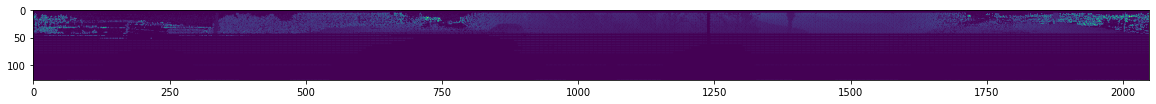

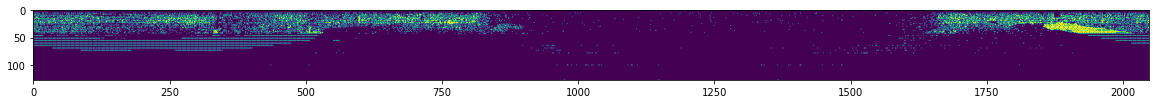

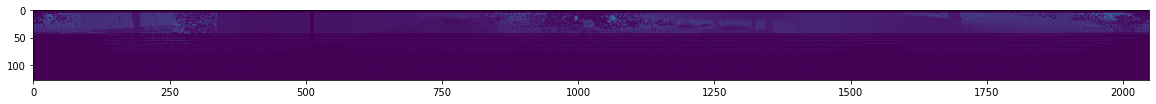

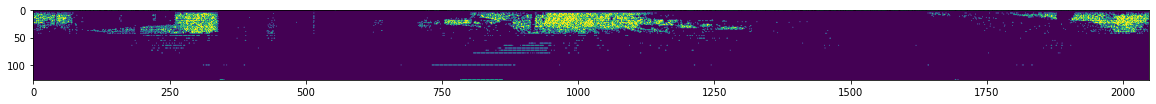

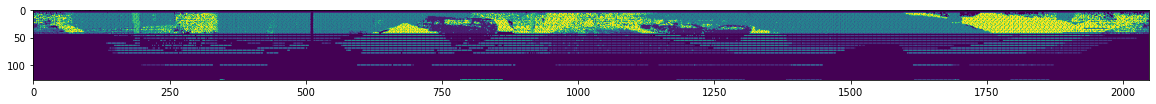

In [6]:
x,y = next(iter(train_loader))
aug = augmentor()
x,y = aug(x,y)
plot_dim = 1
plt.figure(figsize=(20, 6))
plt.imshow(x[0,plot_dim,:,:]);
plt.figure(figsize=(20, 6))
plt.imshow(y[0,0,:,:]);

x,y,l,k, *_ = next(iter(test_loader))
plt.figure(figsize=(20, 6))
plt.imshow(x[0,plot_dim,:,:]);
plt.figure(figsize=(20, 6))
plt.imshow(y[0,0,:,:]);
plt.figure(figsize=(20, 6))
plt.imshow(l[0,0,:,:]);

## Build net

In [7]:
# Reference
# https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py
def init_weights(net, init_type='normal', init_gain=0.02):
    """Initialize network weights.
    Parameters:
        net (network)   -- network to be initialized
        init_type (str) -- the name of an initialization method: normal | xavier | kaiming | orthogonal
        init_gain (float)    -- scaling factor for normal, xavier and orthogonal.
    We use 'normal' in the original pix2pix and CycleGAN paper. But xavier and kaiming might
    work better for some applications. Feel free to try yourself.
    """
    def init_func(m):  # define the initialization function
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
            if init_type == 'normal':
                init.normal_(m.weight.data, 0.0, init_gain)
            elif init_type == 'xavier':
                init.xavier_normal_(m.weight.data, gain=init_gain)
            elif init_type == 'kaiming':
                init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
            elif init_type == 'orthogonal':
                init.orthogonal_(m.weight.data, gain=init_gain)
            else:
                raise NotImplementedError('initialization method [%s] is not implemented' % init_type)
            if hasattr(m, 'bias') and m.bias is not None:
                init.constant_(m.bias.data, 0.0)
        elif classname.find('BatchNorm2d') != -1:  # BatchNorm Layer's weight is not a matrix; only normal distribution applies.
            init.normal_(m.weight.data, 1.0, init_gain)
            init.constant_(m.bias.data, 0.0)

    net.apply(init_func)  # apply the initialization function <init_func>
    

def init_net(net, init_type='normal', init_gain=0.02, gpu_ids=[]):
    """Initialize a network: 1. register CPU/GPU device (with multi-GPU support); 2. initialize the network weights
    Parameters:
        net (network)      -- the network to be initialized
        init_type (str)    -- the name of an initialization method: normal | xavier | kaiming | orthogonal
        gain (float)       -- scaling factor for normal, xavier and orthogonal.
        gpu_ids (int list) -- which GPUs the network runs on: e.g., 0,1,2
    Return an initialized network.
    """
    if len(gpu_ids) > 0:
        assert(torch.cuda.is_available())
        net.to(gpu_ids[0])
        net = torch.nn.DataParallel(net, gpu_ids) # multi-GPUs
    init_weights(net, init_type, init_gain=init_gain)
    return net


class ResBlock(nn.Module):
    def __init__(self, filters, bias=True):
        super(ResBlock, self).__init__()
        self.bn = nn.BatchNorm2d(filters)
        self.activ = nn.LeakyReLU()
        
        layers  = [nn.Conv2d(filters, filters, 3, padding=1, bias=bias)]
        layers += [self.activ]
        layers += [nn.Conv2d(filters, filters, 3, padding=1, bias=bias)]
        self.block = nn.Sequential(*layers)
        
    def forward(self, x):
        bn  = self.bn(x)
        res = self.block(bn)
        out = self.activ(bn+res)
        return out
    
    
class ResBlockEnsemble(nn.Module):
    def __init__(self, filters:int, blocks:int, bias=True):
        super(ResBlockEnsemble, self).__init__()
        self.blocks = [ResBlock(filters, bias=bias) for _ in range(blocks)]
        
        layers  = [nn.Conv2d(filters*(blocks+1), filters, 1, bias=False)]
        #layers += [nn.LeakyReLU()]
        self.ensemble = nn.Sequential(*layers)
        
        self.dummy = nn.Sequential(*self.blocks) # so pytorch can see the layers
        
    def forward(self, x):
        res = [x]
        for block in self.blocks:
            res += [block(res[-1])]
        cat = torch.cat(res, dim=1)
        out = self.ensemble(cat)
        return out
    
    
class ContextBlock(nn.Module):
    def __init__(self, in_filters:int, out_filters:int, bias=True):
        super(ContextBlock, self).__init__()
        relu_and_norm = lambda: [nn.LeakyReLU(), nn.BatchNorm2d(out_filters)]
        
        layers  = [nn.BatchNorm2d(in_filters)]
        layers += [nn.Conv2d(in_filters, out_filters, 5, padding=2, bias=bias)]
        layers += [nn.LeakyReLU()]
        self.layer1 = nn.Sequential(*layers)
        
        layers  = [nn.Conv2d(out_filters, out_filters, 3, dilation=2, padding=2, bias=bias)]
        #layers += [nn.LeakyReLU()]
        self.layer2 = nn.Sequential(*layers)
        
        layers  = [nn.Conv2d(out_filters, out_filters, 2, dilation=2, padding=1, bias=bias)]
        layers += [nn.LeakyReLU()]
        self.layer3 = nn.Sequential(*layers)
        
        layers  = [nn.Conv2d(2*out_filters, out_filters, 1, bias=False)]
        self.attention = nn.Sequential(*layers)
        
        self.layers = [self.layer1, self.layer2]#, self.layer3]

    def forward(self, x):
        out = [x]
        for layer in self.layers:
            out += [layer(out[-1])]
        cat = torch.cat(out[1:], dim=1)
        out = self.attention(cat)
        return out
    
    
class ResContextBlock(nn.Module):
    def __init__(self, in_filters, bias=True):
        super(ResContextBlock, self).__init__()
        out_filters = in_filters
        self.activ = nn.LeakyReLU()
        activ_and_norm = lambda: [self.activ, nn.BatchNorm2d(out_filters)]
        
        layers  = [nn.Conv2d(in_filters, out_filters, 1, stride=1, bias=bias)]
        layers += [self.activ]
        self.skip_path = nn.Sequential(*layers)
        
        layers  = [nn.Conv2d(out_filters, out_filters, 5, padding=2, bias=bias)]
        layers += activ_and_norm()
        layers += [nn.Conv2d(out_filters, out_filters, 3, dilation=3, padding=3, bias=bias)]
        #layers += activ_and_norm()
        self.block = nn.Sequential(*layers)

    def forward(self, x):
        shortcut = self.skip_path(x)
        resA = self.block(shortcut)
        out = self.activ(shortcut + resA)
        return out
    

class ResContextBlock(nn.Module):
    def __init__(self, filters, bias=True):
        super(ResContextBlock, self).__init__()     
        self.layers = ContextBlock(filters, filters, bias=bias)
        self.activ  = nn.LeakyReLU()

    def forward(self, x):
        res = self.layers(x)
        out = self.activ(x + res)
        return out

    
class ConvBlock(nn.Module):
    def __init__(self, in_filters, out_filters):
        super(ConvBlock, self).__init__()
        layers  = [nn.BatchNorm2d(in_filters)]
        layers += [nn.Conv2d(in_filters, out_filters, 7, padding=3)]
        layers += [nn.LeakyReLU()]
        self.block = nn.Sequential(*layers)

    def forward(self, x):
        return self.block(x)


class UpBlock(nn.Module):
    def __init__(self, in_filters, out_filters, drop_out:float=None):
        super(UpBlock, self).__init__()
        layers  = [nn.BatchNorm2d(in_filters)]
        layers += [nn.Dropout2d(p=drop_out)] if drop_out else []
        #layers += [ResContextBlock(in_filters)]
        layers += [nn.PixelShuffle(2)]
        layers += [nn.Conv2d(in_filters>>2, out_filters, 3, padding=1)]
        layers += [nn.LeakyReLU()]
        self.up = nn.Sequential(*layers)
        
        layers  = [nn.Conv2d(2*out_filters, out_filters, 5, padding=2)]
        layers += [nn.LeakyReLU()]
        layers += [ResContextBlock(out_filters, bias=True)]
        self.block = nn.Sequential(*layers)
        
        layers  = [nn.Conv2d(2*out_filters, out_filters, 1, bias=False)]
        layers += [nn.LeakyReLU()]
        self.linear = nn.Sequential(*layers)

    def forward(self, x, skip):
        up  = self.up(x)
        cat = torch.cat((up, skip), dim=1)
        out = self.block(cat)
        #out = self.linear(cat)
        return out
    
    
class DownBlock(nn.Module):
    def __init__(self, in_filters, out_filters, drop_out:float=None):
        super(DownBlock, self).__init__()
        layers  = [ResContextBlock(in_filters, bias=True)]
        self.pre = nn.Sequential(*layers)
        
        layers  = [nn.Dropout2d(p=drop_out)] if drop_out else []
        layers += [nn.Conv2d(in_filters, out_filters, 5, stride=2, padding=2)]
        layers += [nn.LeakyReLU()]
        self.down = nn.Sequential(*layers)

    def forward(self, x):
        pre = self.pre(x)
        down = self.down(pre)
        return down, pre
    
############## Salsa blocks ##########
class SalsaResContextBlock(nn.Module):
    def __init__(self, in_filters, out_filters, bias=True):
        super(SalsaResContextBlock, self).__init__()
        relu_and_norm = lambda: [nn.LeakyReLU(), nn.BatchNorm2d(out_filters)]
        self.activ = nn.LeakyReLU()
        
        layers  = [nn.Conv2d(in_filters, out_filters, 1, bias=bias)]
        layers += [nn.LeakyReLU()]
        self.skip_path = nn.Sequential(*layers)
        
        layers  = [nn.Conv2d(in_filters, out_filters, 5, padding=2, bias=bias)]
        layers += relu_and_norm()
        layers += [nn.Conv2d(out_filters, out_filters, 3, dilation=3, padding=3, bias=bias)]
        self.block = nn.Sequential(*layers)

    def forward(self, x):
        shortcut = self.skip_path(x)
        resA = self.block(x)
        out = self.activ(shortcut + resA)
        return out


class ResBlock(nn.Module):
    def __init__(self, in_filters, out_filters, kernel_size=3, stride=1,
                 pooling=True, drop_out:float=0.2, bias=True):
        super(ResBlock, self).__init__()
        self.pooling = pooling
        self.drop_out = drop_out
        relu_and_norm = lambda: [nn.LeakyReLU(), nn.BatchNorm2d(out_filters)]
        
        self.activ = nn.LeakyReLU()

        layers  = [nn.Conv2d(in_filters, out_filters, 1, stride=stride, bias=bias)]
        layers += [nn.LeakyReLU()]
        self.skip_path = nn.Sequential(*layers)

        layers  = [nn.Conv2d(in_filters, out_filters, 3, padding=1, bias=bias)]
        layers += relu_and_norm()
        self.path1 = nn.Sequential(*layers)

        layers  = [nn.Conv2d(out_filters, out_filters, 3, dilation=2, padding=2, bias=bias)]
        layers += relu_and_norm()
        self.path2 = nn.Sequential(*layers)

        layers  = [nn.Conv2d(out_filters, out_filters, 2, dilation=2, padding=1, bias=bias)]
        layers += [nn.LeakyReLU()]
        self.path3 = nn.Sequential(*layers)

        layers  = [nn.Conv2d(3*out_filters, out_filters, 1, bias=bias)]
        self.path4 = nn.Sequential(*layers)

        self.dropout = nn.Dropout2d(p=drop_out)
        if pooling:
            #self.pool = nn.AvgPool2d(kernel_size=kernel_size, stride=2, padding=1)
            layers  = [nn.PixelUnshuffle(2)]
            layers += [nn.Conv2d(4*out_filters, out_filters, 1, bias=bias)]
            layers += [nn.LeakyReLU()]
            self.pool = nn.Sequential(*layers)

    def forward(self, x):
        shortcut = self.skip_path(x)

        resA1 = self.path1(x)
        resA2 = self.path2(resA1)
        resA3 = self.path3(resA2)

        concat = torch.cat((resA1, resA2, resA3),dim=1)
        resA = self.path4(concat)
        resA += shortcut
        resA = self.activ(resA)

        resB = self.dropout(resA) if self.drop_out else resA

        if self.pooling:
            resB = self.pool(resB)
            return resB, resA
        return resB


class UpBlock(nn.Module):
    def __init__(self, in_filters, out_filters, drop_out:float=None):
        super(UpBlock, self).__init__()
        relu_and_norm = lambda: [nn.LeakyReLU(), nn.BatchNorm2d(out_filters)]
        
        layers  = [nn.PixelShuffle(2)]
        #layers += [nn.Conv2d(in_filters>>2, out_filters, 1, padding=0)]
        self.up_path = nn.Sequential(*layers)

        layers  = [nn.Conv2d(in_filters//4 + 2*out_filters, out_filters, 1, padding=0)]
        layers += relu_and_norm()
        self.path1 = nn.Sequential(*layers)
        
        layers  = [nn.Conv2d(out_filters, out_filters, 3, dilation=1, padding=1)]
        layers += [nn.LeakyReLU()]
        self.path2 = nn.Sequential(*layers)
        
        layers  = [nn.Conv2d(2*out_filters, out_filters, 1)]
        layers += [nn.Dropout2d(p=drop_out)] if drop_out else []
        layers += relu_and_norm()
        self.path4 = nn.Sequential(*layers)

    def forward(self, x, skip):
        upA = self.up_path(x) 
        upB = torch.cat((upA,skip),dim=1)
    
        upE1 = self.path1(upB)
        upE2 = self.path2(upE1)

        concat = torch.cat((upE1, upE2),dim=1)
        upE = self.path4(concat)
        return upE
    
############## Combined ##############   
class Combined(nn.Module):
    def __init__(self):
        super(Combined, self).__init__()
        in_chnl = next(iter(train_loader))[0].shape[1]
        
        name2block = {
            'conv':lambda i,o: ConvBlock(i, o),
            'res': lambda i,o: ResBlock(i,bias=True), 
            'eres':lambda i,o: ResBlockEnsemble(i, 10, bias=True),
            'cres':lambda i,o: ResContextBlock(i, bias=True),
            #'cntx':lambda i,o: ContextBlock(i, o, bias=True),
            'down':lambda i,o: DownBlock(i, o, drop_out=False),
            'up':  lambda i,o: UpBlock(i, o, drop_out=False),
            'c'  : lambda i,o: nn.Conv2d(i, o, 5, padding=2),
            'sup' :lambda i,o: UpBlock(i, o, drop_out=False),
            'supd':lambda i,o: UpBlock(i, o, drop_out=0.37),
            'sdwn':lambda i,o: ResBlock(i, o, pooling=True,  drop_out=False),
            'sres':lambda i,o: ResBlock(i, o, pooling=False, drop_out=False),
            'cntx':lambda i,o: SalsaResContextBlock(i, o),
        }
        
        
        layer_list = [
            'cntx-32', 'cntx-32', 'marker', # Pre process
            'sdwn-64', 'sdwn-128', 'sdwn-256', 'marker', # Encode
            'sres-256', 'marker', # Process features
            'sup-128', 'sup-64', 'sup-32', 'marker', # Decode
            'cntx-32', 'c-1', # Post process
        ]
        # Extract markers so we know where up/down layers start
        markers = [i for i,x in enumerate(layer_list) if x=='marker']
        markers = [x-i for i,x in enumerate(markers)]
        layer_list = [l for l in layer_list if l != 'marker']
        
        layers = []
        for idx, layer in enumerate(layer_list):
            block_name, out_chnl = layer.split('-')
            out_chnl = int(out_chnl)
            layers += [name2block[block_name](in_chnl, out_chnl)]
            in_chnl = out_chnl
        
        m = markers
        self.pre  = nn.Sequential(*layers[   0:m[0]])
        self.down =                layers[m[0]:m[1]]
        self.mid  = nn.Sequential(*layers[m[1]:m[2]])
        self.up   =                layers[m[2]:m[3]]
        self.post = nn.Sequential(*layers[m[3]:])
        
        self.dummy = nn.Sequential(*layers) # so pytorch can see the layers
        
    def forward(self, x):
        # Encode
        pre  = self.pre(x)
        skips = [pre]
        down = pre
        for d in self.down:
            down, skip = d(down)
            skips += [skip]
        mid = self.mid(down)
        #skips = skips[:-1] # because last "skip" is not a skip
        skips = [*reversed(skips)] # decoders want reverse order
        
        # Decode
        up  = mid
        for u,s in zip(self.up, skips):
            up = u(up,s)
        m = self.post(up)
        m = m - torch.finfo(torch.float32).max * (x[:,0] == -1).reshape(m.shape) # leverage that -1 -> -inf
        return m


def summarise():
    print('\nCombined:')
    s = next(iter(train_loader))[0].shape
    print(info_summary(Combined().to(1), 
                       input_size=s,
                       device=1,
                       verbose=0,
                       depth=5))
summarise()


Combined:
Layer (type:depth-idx)                        Output Shape              Param #
Combined                                      --                        --
├─Sequential: 1-1                             [1, 32, 128, 2048]        --
│    └─SalsaResContextBlock: 2-1              [1, 32, 128, 2048]        --
│    │    └─Sequential: 3-1                   [1, 32, 128, 2048]        --
│    │    │    └─Conv2d: 4-1                  [1, 32, 128, 2048]        96
│    │    │    └─LeakyReLU: 4-2               [1, 32, 128, 2048]        --
│    │    └─Sequential: 3-2                   [1, 32, 128, 2048]        --
│    │    │    └─Conv2d: 4-3                  [1, 32, 128, 2048]        1,632
│    │    │    └─LeakyReLU: 4-4               [1, 32, 128, 2048]        --
│    │    │    └─BatchNorm2d: 4-5             [1, 32, 128, 2048]        64
│    │    │    └─Conv2d: 4-6                  [1, 32, 128, 2048]        9,248
│    │    └─LeakyReLU: 3-3                    [1, 32, 128, 2048]        --
│  

## Train net

In [8]:
import torch.optim as optim
import torchvision.transforms as transforms
import itertools
import os
import cv2

# from https://discuss.pytorch.org/t/simple-way-to-inverse-transform-normalization/4821
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor


class ToNumpy(object):
    def __call__(self, data):
        return data.cpu().detach().numpy().transpose(0, 2, 3, 1)


def set_requires_grad(nets, requires_grad=False):
    """Set requies_grad=Fasle for all the networks to avoid unnecessary computations
    Parameters:
        nets (network list)   -- a list of networks
        requires_grad (bool)  -- whether the networks require gradients or not
    """
    if not isinstance(nets, list):
        nets = [nets]
    for net in nets:
        if net is not None:
            for param in net.parameters():
                param.requires_grad = requires_grad

                
# from https://github.com/leaderj1001/minimal-cyclegan/blob/master/main.py
def train(train_loader, generator, optimizer, loss, epoch, writer, config):
    generator.train()
    aug = augmentor()

    for i, (data, label) in enumerate(train_loader):
        
        if config['run']['cuda']:
            data = data.to(config['run']['device'])
            label = label.to(config['run']['device'])

        # Train generator (segmenter)
        data, label = aug(data,label)
        optimizer.zero_grad()
        gen = generator(data)
        loss_G = loss(gen, label)
        loss_G.backward()
        nn.utils.clip_grad_norm_(generator.parameters(), 5)
        optimizer.step()
        
        # Log train info
        gen = torch.sigmoid(gen) # since sigmoid is built in the loss
        toNumpy = lambda x: x.cpu().detach().numpy()
        accuracy = lambda x,y: (np.round(x)==np.round(y)).mean()
        f1 = lambda y,x: f1_score(np.round(x).ravel(),y.ravel())
        gen, label = toNumpy(gen), toNumpy(label)
        # mean of funcion f applied to each channel for each image in batch
        apply = lambda f: np.mean([f(d, r) for da,ra in zip(label, gen) for d,r in zip(da,ra)])
        metrics = {
            'Loss_gen': loss_G.item(), 
            'Accuracy': apply(accuracy),
            'F1':apply(f1),
        }
        iteration = len(train_loader)*(epoch-1)+i
        for k,v in metrics.items():
            writer.add_scalars(k, {config['train']['log_name']:v}, iteration)
        
        # Display train info
        print(f'\r[Epoch: {epoch:4d}][{1+i:4d}]',
              *[f'{k}: {v:.4f},' for k,v in metrics.items()],
              end=' '*10)

        # Create checkpoint
        if config['train']['checkpoint']:
            if i % config['train']['checkpoint'] == 0:
                if not os.path.isdir('./runs/'):
                    os.mkdir('./runs/')

                torch.save({
                    'generator': generator.state_dict(),
                    'optimizer': optimizer.state_dict(),
                    'start_epoch': epoch,
                }, './runs/model_{}_{}.pth'.format(epoch, i))


def evaluation(test_loader, generator, config):
    generator.eval()

    transform_inv = transforms.Compose([UnNormalize(mean=(0.0, 0.0), std=(1.0, 1.0)), ToNumpy()])
    toNumpy = lambda x: x.cpu().detach().numpy()
    accuracy = lambda x,y: (np.round(x)==np.round(y)).mean()
    tot_metrics = {}
        
    saved = 0
    with torch.no_grad():
        for i, (data, bin_label, labels, keys, P, mask, (x,y,r)) in enumerate(test_loader):
            
            if config['run']['cuda']:
                data = data.to(config['run']['device'])  

            start = time()
            gen = generator(data)
            gen = torch.sigmoid(gen) # since sigmoid is built in the loss
            salsa_time = 1000*(time()-start)
            
            someone_is_blocking_gpu1 = True
            if someone_is_blocking_gpu1:
                data = data.to(0)
                labels = labels.to(0)
                r = r.to(0)
                x = x.to(0)
                y = y.to(0)
                mask = mask.to(0)
                gen = gen.to(0)
            
            # Do eval & print it
            start = time()
            full_pred, extra_metrics = extra_eval(r[0], x[0], y[0], data[0][1], gen[0], ~mask[0]) # only works with BS=1
            infer_time = 1000*(time()-start) + salsa_time
            f1 = lambda y,x: f1_score(np.round(x).ravel(),y.ravel())
            np_bin_label, np_gen = toNumpy(bin_label), toNumpy(gen)
            # mean of funcion f applied to each channel for each image in batch
            apply = lambda f: np.mean([f(d, r) for da,ra in zip(np_bin_label, np_gen) for d,r in zip(da,ra)])
            metrics = { 
                'Accuracy': apply(accuracy),
                'F1':apply(f1),
                'mean_diff':np_gen.mean()-np_bin_label.mean(),
                '2d_time':salsa_time,
                'Time':infer_time,
            }
            metrics.update(extra_metrics)
            tot_metrics = {k:tot_metrics.get(k,0) + v for k,v in metrics.items()}
            print(f'\r[Eval Iter: {1+i:4d}]',
                  *[f'{k}: {v/(1+i):.4f},' for k,v in tot_metrics.items()],
                  end=' '*10)
            
            # Log eval info
            gen = torch.cat([gen,data[:,1].reshape(gen.shape)],dim=1) # add range data for unprojection
            data = {'input':data, 
                    'out':gen}
            data = {k:transform_inv(v) for k,v in data.items()}

            if saved < config['eval']['save']:
                P = toNumpy(P)
                
                if not os.path.isdir('results'):
                    os.mkdir('results')
                
                max_saves = config['eval']['save'] - saved
                batch_size = gen.shape[0]
                for j in range(0, min(batch_size, max_saves)):
                    number = batch_size * i + j
                    saved += 1
                    for k,image in data.items():
                        name = f'{k}_{number:0>4d}'
                        (*folder_id,), (*file_name,) = keys
                        save_data('./results', name, image[j], labels[j], (folder_id[j],file_name[j]), (P[j],full_pred) )
                        

def extra_eval(full_r, full_x, full_y, proj_r, pred, og_labels):
    "Extra eval that imputes labels for obscured points"
    from KNN import KNN
    
    # Impute values using knn
    if 'knn' not in extra_eval.__dir__(): # dirty code to dodge the prints in knn init
        params= {
        "knn"   : 5,
        "search": 35,
        "sigma" : 1.0,
        "cutoff": 35.0,
        }
        nclasses = 3
        knn = KNN(params, nclasses)
        extra_eval.__setattr__('knn', knn)
    else:
        knn = extra_eval.knn
    
    round_pred = pred.round() # discard certainty as this knn implementation does not support it
    full_x, full_y = full_x.long(), full_y.long()
    full_pred = knn(proj_r, full_r, round_pred[0]+1, full_x, full_y) # +1 and then...
    full_pred -= 1 # -1! Because 0 is reservered for unlabled
    
    # Evaluate with ground truth
    accuracy = lambda x,y: (np.round(x)==np.round(y)).mean()
    f1 = lambda x,y: f1_score(np.round(x).ravel(),y.ravel())
    preci = lambda x,y: precision_score(np.round(x).ravel(),y.ravel())
    recall = lambda x,y: recall_score(np.round(x).ravel(),y.ravel())
    toNumpy = lambda x: x.cpu().detach().numpy()
    full_pred = toNumpy(full_pred)
    og_labels = toNumpy(og_labels)
    metrics = {
        'full_acc': accuracy(og_labels, full_pred),
        'full_f1' : f1(og_labels, full_pred),
        'recall'  : recall(og_labels, full_pred),
        'preci'   : preci(og_labels, full_pred),
    }

    full_pred[full_pred != og_labels] = 2 # change labels for misslabeled
    return full_pred, metrics

    
def save_data(folder, name, projection, labels=None, keys:tuple=None, raw_cloud:tuple=None):
    "Saves a 2d and an unprojected 3d image"
    
    def normalize(img):
        i = img.copy()
        power = 1/4 # prevents extremes from using the full pallete
        i[i<0] = -np.power(-i[i<0],power)
        i[i>0] =  np.power( i[i>0],power)
        i -= i.min()
        return i / i.max()
    
    # make 2d image  
    x = projection
    img = np.concatenate([normalize(x[:,:,i]) for i in range(x.shape[2])], axis=0)
    
    if not os.path.isdir('./results/2d'):
        os.mkdir('./results/2d')
    plt.imsave(folder+'/2d/'+name+'.png', img)
    
    if keys: # make 3d image
        folder_id, file_name = keys
        folder = folder+'/'+'_'.join(name.split('_')[:1])
        if raw_cloud:
            points, lab = raw_cloud
            write_one_kitty(folder, {file_name:points}, labels={file_name:lab})
            return
        points, mask = unproject(projection, return_mask=True)
        frame = {file_name:points}
        
        label = labels
        if label != None:
            # Flatten labels the same way unprojection is done
            channel, height, width = labels.shape
            label = -np.ones((height*width, channel), dtype=np.int16)
            l = labels.detach().cpu().numpy()
            for y,x in product(range(height), range(width)):
                index = y*width+x
                label[index] = l[:,y,x]
            label = {file_name:label[mask]}
        write_one_kitty(folder, frame, labels=label)
        

def main():
    checkpoint = (17,0)
    do_train = 0#True
    config = yaml.safe_load(open('./net_config.yaml'))
    
    torch.manual_seed(config['run']['seed'])
    torch.cuda.manual_seed(config['run']['seed'])
    np.random.seed(config['run']['seed'])
    
    generator = Combined()

    if config['run']['cuda']:
        generator = generator.to(config['run']['device'])

    optimizer = optim.Adam(
        itertools.chain(generator.parameters()), 
        lr=config['generator']['lr'], 
        betas=(0.5, 0.9),
        amsgrad=True)

    if checkpoint:
        start_epoch, iteration = checkpoint
        path = './runs/model_{}_{}.pth'.format(start_epoch, iteration)

        checkpoint = torch.load(path)
        generator.load_state_dict(checkpoint['generator'])
        optimizer.load_state_dict(checkpoint['optimizer'])

    else:
        for net in [generator]:
            init_net(net, init_type='kaiming', init_gain=0.02, gpu_ids=[config['run']['device']])
        start_epoch = 1

    if do_train:
        loss = nn.BCEWithLogitsLoss()
        writer = SummaryWriter('results/'+'logs')
        
        for epoch in range(start_epoch, config['train']['max_epoch']+1):
            train(train_loader, generator, optimizer, loss, epoch, writer, config)
            print()            
        writer.close()
        
    evaluation(test_loader, generator, config)
    print()

main()

[Eval Iter:  410] Accuracy: 0.9969, F1: 0.9587, mean_diff: -0.0004, 2d_time: 2.9497, Time: 311.5982, full_acc: 0.9902, full_f1: 0.9499, recall: 0.9319, preci: 0.9707,          


In [ ]:
### Big dump of snapshots

## baseline: 2 channel, 17 search, 7 k, 1 sigma, 5 cutoff
# 1  : Accuracy: 0.9650, F1: 0.0667, x_mean: 0.0072, y_mean: 0.0354, Time: 254.1340, full_acc: 0.9088, full_f1: 0.0096, recall: 0.0049, preci: 0.2957,  
# 2  : Accuracy: 0.9964, F1: 0.9508, x_mean: 0.0424, y_mean: 0.0354, Time: 258.7339, full_acc: 0.9853, full_f1: 0.9229, recall: 0.9347, preci: 0.9132,   
# 3  : Accuracy: 0.9965, F1: 0.9540, x_mean: 0.0363, y_mean: 0.0354, Time: 260.8723, full_acc: 0.9859, full_f1: 0.9269, recall: 0.9262, preci: 0.9300,      
# 4  : Accuracy: 0.9967, F1: 0.9565, x_mean: 0.0354, y_mean: 0.0354, Time: 261.0135, full_acc: 0.9864, full_f1: 0.9293, recall: 0.9301, preci: 0.9305, 
# 5  : Accuracy: 0.9967, F1: 0.9565, x_mean: 0.0369, y_mean: 0.0354, Time: 259.2974, full_acc: 0.9863, full_f1: 0.9293, recall: 0.9301, preci: 0.9305, 
# 6  : Accuracy: 0.9965, F1: 0.9520, x_mean: 0.0437, y_mean: 0.0354, Time: 258.9696, full_acc: 0.9858, full_f1: 0.9257, recall: 0.9305, preci: 0.9231, 
# 7  : Accuracy: 0.9967, F1: 0.9571, x_mean: 0.0351, y_mean: 0.0354, Time: 258.8893, full_acc: 0.9864, full_f1: 0.9297, recall: 0.9285, preci: 0.9329, 
# 8  : Accuracy: 0.9966, F1: 0.9546, x_mean: 0.0372, y_mean: 0.0354, Time: 259.0238, full_acc: 0.9860, full_f1: 0.9265, recall: 0.9300, preci: 0.9253,  
# 9  : Accuracy: 0.9968, F1: 0.9572, x_mean: 0.0357, y_mean: 0.0354, Time: 260.6648, full_acc: 0.9863, full_f1: 0.9292, recall: 0.9318, preci: 0.9286,  

# 10 : Accuracy: 0.9967, F1: 0.9565, x_mean: 0.0363, y_mean: 0.0354, Time: 251.6274, full_acc: 0.9862, full_f1: 0.9284, recall: 0.9305, preci: 0.9283
# 20 : Accuracy: 0.9968, F1: 0.9559, x_mean: 0.0358, y_mean: 0.0354, Time: 252.1093, full_acc: 0.9864, full_f1: 0.9284, recall: 0.9334, preci: 0.9253,
# 30 : Accuracy: 0.9967, F1: 0.9550, x_mean: 0.0338, y_mean: 0.0354, Time: 251.4381, full_acc: 0.9861, full_f1: 0.9276, recall: 0.9289, preci: 0.9282,
# 40 : Accuracy: 0.9968, F1: 0.9568, x_mean: 0.0338, y_mean: 0.0354, Time: 250.5077, full_acc: 0.9863, full_f1: 0.9288, recall: 0.9277, preci: 0.9320,
# 50 : Accuracy: 0.9968, F1: 0.9566, x_mean: 0.0343, y_mean: 0.0354, Time: 251.3105, full_acc: 0.9863, full_f1: 0.9286, recall: 0.9319, preci: 0.9271, 
# 60 : Accuracy: 0.9968, F1: 0.9571, x_mean: 0.0343, y_mean: 0.0354, Time: 250.4500, full_acc: 0.9864, full_f1: 0.9291, recall: 0.9318, preci: 0.9282,  
# 70 : Accuracy: 0.9967, F1: 0.9558, x_mean: 0.0341, y_mean: 0.0354, Time: 250.7824, full_acc: 0.9862, full_f1: 0.9284, recall: 0.9311, preci: 0.9274,  
# 80 : Accuracy: 0.9966, F1: 0.9545, x_mean: 0.0343, y_mean: 0.0354, Time: 250.0367, full_acc: 0.9860, full_f1: 0.9268, recall: 0.9314, preci: 0.9240,  
# 90 : Accuracy: 0.9966, F1: 0.9541, x_mean: 0.0341, y_mean: 0.0354, Time: 252.0220, full_acc: 0.9860, full_f1: 0.9266, recall: 0.9291, preci: 0.9261, 
# 100: Accuracy: 0.9966, F1: 0.9552, x_mean: 0.0341, y_mean: 0.0354, full_acc: 0.9861, full_f1: 0.9278, 

## train F1 was ~98% (2.5% overfit)


## xyz channel/5 channel test
# 9  : Accuracy: 0.9966, F1: 0.9531, mean_diff: 0.0008, 2d_time: 3.8750, Time: 224.5992, full_acc: 0.9856, full_f1: 0.9229, recall: 0.9388, preci: 0.9095,  
# 50 : Accuracy: 0.9964, F1: 0.9517, mean_diff:-0.0005, 2d_time: 3.4568, Time: 219.7298, full_acc: 0.9851, full_f1: 0.9211, recall: 0.9350, preci: 0.9099, 
# 2 channel
# 9  : Accuracy: 0.9967, F1: 0.9559, mean_diff: 0.0016, 2d_time: 3.8902, Time: 221.4565, full_acc: 0.9863, full_f1: 0.9288, recall: 0.9330, preci: 0.9267,

## xyz channels are red herrings


## add dropout in pix2pix fashion
# 2  : Accuracy: 0.9963, F1: 0.9510, mean_diff: 0.0013, 2d_time: 3.7918, Time: 220.0552, full_acc: 0.9855, full_f1: 0.9249, recall: 0.9256, preci: 0.9268,  
# 3  : Accuracy: 0.9966, F1: 0.9546, mean_diff: 0.0011, 2d_time: 3.9519, Time: 224.1839, full_acc: 0.9862, full_f1: 0.9283, recall: 0.9294, preci: 0.9293,  
# 4  : Accuracy: 0.9966, F1: 0.9549, mean_diff: 0.0050, 2d_time: 3.9873, Time: 223.8832, full_acc: 0.9862, full_f1: 0.9283, recall: 0.9332, preci: 0.9253,  
# 5  : Accuracy: 0.9965, F1: 0.9537, mean_diff: 0.0080, 2d_time: 3.6283, Time: 220.7444, full_acc: 0.9861, full_f1: 0.9275, recall: 0.9302, preci: 0.9271,  
# 6  : Accuracy: 0.9966, F1: 0.9552, mean_diff: 0.0016, 2d_time: 3.3783, Time: 214.9520, full_acc: 0.9860, full_f1: 0.9282, recall: 0.9290, preci: 0.9296,  
# 7  : Accuracy: 0.9964, F1: 0.9525, mean_diff: 0.0019, 2d_time: 3.3181, Time: 215.0417, full_acc: 0.9856, full_f1: 0.9256, recall: 0.9268, preci: 0.9269, 
# 8  : Accuracy: 0.9966, F1: 0.9552, mean_diff: 0.0012, 2d_time: 3.3363, Time: 214.8969, full_acc: 0.9862, full_f1: 0.9284, recall: 0.9299, preci: 0.9289,  
# 9  : Accuracy: 0.9965, F1: 0.9533, mean_diff: 0.0025, 2d_time: 3.9084, Time: 222.6137, full_acc: 0.9859, full_f1: 0.9267, recall: 0.9312, preci: 0.9243, 
# 10 : Accuracy: 0.9955, F1: 0.9396, mean_diff: 0.0040, 2d_time: 3.9336, Time: 222.4515, full_acc: 0.9834, full_f1: 0.9127, recall: 0.9277, preci: 0.9013, 
# 20 : Accuracy: 0.9962, F1: 0.9491, mean_diff:-0.0019, 2d_time: 3.7802, Time: 222.3872, full_acc: 0.9852, full_f1: 0.9220, recall: 0.9195, preci: 0.9270, 
# 40 : Accuracy: 0.9963, F1: 0.9488, mean_diff:-0.0010, 2d_time: 3.8104, Time: 222.6953, full_acc: 0.9849, full_f1: 0.9199, recall: 0.9265, preci: 0.9156,  
# 80 : Accuracy: 0.9960, F1: 0.9443, mean_diff:-0.0008, 2d_time: 3.7484, Time: 221.3204, full_acc: 0.9842, full_f1: 0.9153, recall: 0.9251, preci: 0.9080, 
# 100: Accuracy: 0.9955, F1: 0.9366, mean_diff:-0.0011, 2d_time: 3.9774, Time: 224.4596, full_acc: 0.9824, full_f1: 0.9044, recall: 0.9182, preci: 0.8941,  

## faster learning but converges to an over-generalized point. dropout improves statistical performance at the expence of actual performance


## subset of data
# 20*: Accuracy: 0.9961, F1: 0.9475, mean_diff: -0.0016, 2d_time: 4.0661, Time: 225.5599, full_acc: 0.9844, full_f1: 0.9173, recall: 0.9217, preci: 0.9158, 
## *^ pre trained init and dropout
# 2  : Accuracy: 0.9946, F1: 0.9263, mean_diff: 0.0016, 2d_time: 3.9489, Time: 221.5853, full_acc: 0.9821, full_f1: 0.9076, recall: 0.9192, preci: 0.8987, 
# 3  : Accuracy: 0.9946, F1: 0.9279, mean_diff: 0.0038, 2d_time: 3.9532, Time: 221.3314, full_acc: 0.9820, full_f1: 0.9048, recall: 0.9170, preci: 0.8987, 
# 4  : Accuracy: 0.9955, F1: 0.9390, mean_diff: 0.0097, 2d_time: 3.8665, Time: 220.6000, full_acc: 0.9837, full_f1: 0.9139, recall: 0.9312, preci: 0.9003, 
# 5  : Accuracy: 0.9959, F1: 0.9441, mean_diff: 0.0029, 2d_time: 4.0222, Time: 222.0340, full_acc: 0.9842, full_f1: 0.9163, recall: 0.9322, preci: 0.9041, 
# 8  : Accuracy: 0.9960, F1: 0.9465, mean_diff: 0.0007, 2d_time: 3.9844, Time: 222.4337, full_acc: 0.9847, full_f1: 0.9199, recall: 0.9280, preci: 0.9150, 
# 9  : Accuracy: 0.9956, F1: 0.9412, mean_diff:-0.0003, 2d_time: 3.9427, Time: 222.0122, full_acc: 0.9846, full_f1: 0.9203, recall: 0.9246, preci: 0.9193, 
# 10 : Accuracy: 0.9960, F1: 0.9462, mean_diff: 0.0023, 2d_time: 3.8029, Time: 225.4904, full_acc: 0.9844, full_f1: 0.9177, recall: 0.9368, preci: 0.9021, 
# 11 : Accuracy: 0.9960, F1: 0.9468, mean_diff:-0.0003, 2d_time: 4.0531, Time: 221.7155, full_acc: 0.9847, full_f1: 0.9203, recall: 0.9294, preci: 0.9147,  
# 12 : Accuracy: 0.9952, F1: 0.9346, mean_diff: 0.0084, 2d_time: 3.9726, Time: 221.6526, full_acc: 0.9824, full_f1: 0.9072, recall: 0.9360, preci: 0.8841, 
# 13 : Accuracy: 0.9960, F1: 0.9464, mean_diff: 0.0001, 2d_time: 3.9655, Time: 220.7840, full_acc: 0.9844, full_f1: 0.9191, recall: 0.9335, preci: 0.9081, 
# 15 : Accuracy: 0.9958, F1: 0.9436, mean_diff: 0.0001, 2d_time: 3.8309, Time: 221.2351, full_acc: 0.9837, full_f1: 0.9137, recall: 0.9245, preci: 0.9072, 
# 20 : Accuracy: 0.9958, F1: 0.9429, mean_diff: 0.0009, 2d_time: 3.4676, Time: 217.0242, full_acc: 0.9837, full_f1: 0.9132, recall: 0.9368, preci: 0.8941, 
# 40 : Accuracy: 0.9956, F1: 0.9398, mean_diff:-0.0001, 2d_time: 3.7325, Time: 225.1744, full_acc: 0.9835, full_f1: 0.9126, recall: 0.9341, preci: 0.8958, 
# 80 : Accuracy: 0.9951, F1: 0.9326, mean_diff: 0.0005, 2d_time: 3.8780, Time: 225.4522, full_acc: 0.9828, full_f1: 0.9078, recall: 0.9350, preci: 0.8859, 
# 100: Accuracy: 0.9947, F1: 0.9260, mean_diff: 0.0011, 2d_time: 4.0517, Time: 226.6786, full_acc: 0.9821, full_f1: 0.9036, recall: 0.9358, preci: 0.8776, 

## subset -> not general enough


## augmented run
# 10 : Accuracy: 0.9966, F1: 0.9561, mean_diff: 0.0000, 2d_time: 3.8602, Time: 227.6148, full_acc: 0.9862, full_f1: 0.9288, recall: 0.9283, preci: 0.9313
# 13 : Accuracy: 0.9967, F1: 0.9557, mean_diff: 0.0014, 2d_time: 4.0758, Time: 229.1675, full_acc: 0.9860, full_f1: 0.9276, recall: 0.9334, preci: 0.9237
# 15 : Accuracy: 0.9969, F1: 0.9584, mean_diff:-0.0019, 2d_time: 3.8289, Time: 226.8304, full_acc: 0.9866, full_f1: 0.9307, recall: 0.9285, preci: 0.9346
# 16 : Accuracy: 0.9968, F1: 0.9581, mean_diff: 0.0000, 2d_time: 3.8267, Time: 227.1171, full_acc: 0.9865, full_f1: 0.9301, recall: 0.9334, preci: 0.9285
# 17 : Accuracy: 0.9969, F1: 0.9585, mean_diff:-0.0004, 2d_time: 3.9600, Time: 227.8150, full_acc: 0.9865, full_f1: 0.9302, recall: 0.9322, preci: 0.9300
# 18 : Accuracy: 0.9968, F1: 0.9577, mean_diff:-0.0010, 2d_time: 3.9600, Time: 226.2140, full_acc: 0.9864, full_f1: 0.9299, recall: 0.9280, preci: 0.9337
# 20 : Accuracy: 0.9968, F1: 0.9576, mean_diff:-0.0017, 2d_time: 4.0776, Time: 227.9610, full_acc: 0.9865, full_f1: 0.9301, recall: 0.9283, preci: 0.9337
# 25 : Accuracy: 0.9969, F1: 0.9583, mean_diff:-0.0008, 2d_time: 4.0441, Time: 228.2648, full_acc: 0.9866, full_f1: 0.9301, recall: 0.9307, preci: 0.9313
# 30 : Accuracy: 0.9968, F1: 0.9572, mean_diff:-0.0006, 2d_time: 4.0753, Time: 228.5699, full_acc: 0.9864, full_f1: 0.9293, recall: 0.9317, preci: 0.9288
# 50 : Accuracy: 0.9966, F1: 0.9548, mean_diff:-0.0004, 2d_time: 3.8643, Time: 225.9042, full_acc: 0.9859, full_f1: 0.9264, recall: 0.9329, preci: 0.9218

## augmenting is good


## 4 deep u-net salsa
# 10 : Accuracy: 0.9932, F1: 0.9071, mean_diff: 0.0092, 2d_time: 4.7950, Time: 225.9929, full_acc: 0.9773, full_f1: 0.8804, recall: 0.9345, preci: 0.8370
# 15 : Accuracy: 0.9967, F1: 0.9560, mean_diff:-0.0012, 2d_time: 4.7547, Time: 227.0301, full_acc: 0.9862, full_f1: 0.9285, recall: 0.9293, preci: 0.9298
# 20 : Accuracy: 0.9966, F1: 0.9546, mean_diff:-0.0017, 2d_time: 4.9137, Time: 226.5704, full_acc: 0.9859, full_f1: 0.9270, recall: 0.9286, preci: 0.9275
# 25 : Accuracy: 0.9963, F1: 0.9513, mean_diff: 0.0005, 2d_time: 4.6791, Time: 227.2745, full_acc: 0.9853, full_f1: 0.9235, recall: 0.9356, preci: 0.9140

In [10]:
#!pip install torch==1.6.0 torchvision==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html
!zip -r ./results/results.zip ./results/input ./results/out ./results/2d > /dev/null

In [9]:
!tensorboard --logdir="results/logs" --port=6060

TensorFlow installation not found - running with reduced feature set.

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.8.0 at http://localhost:6060/ (Press CTRL+C to quit)
^C


### Notes
- Kernels after pixelunshuffle is bad, mmkay (they act as if dilated)
- Normalizing residuals is a bad idea (prevents mean value subtraction which we want for relu)